In [2]:
import os
os.getcwd()
import pandas as pd
from sodapy import Socrata
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN
import numpy as np
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import json

Loading in and Preprocessing data

In [38]:
Traffic_Crashes_Crashes_df = pd.read_csv(r'data/Traffic_Crashes_Crashes.csv')
Traffic_Crashes_People_df = pd.read_csv(r'data/Traffic_Crashes_People.csv')
Traffic_Crashes_Crashes=Traffic_Crashes_Crashes_df[['CRASH_RECORD_ID','CRASH_DATE','POSTED_SPEED_LIMIT','TRAFFIC_CONTROL_DEVICE','WEATHER_CONDITION','LIGHTING_CONDITION','LATITUDE','LONGITUDE']]
Traffic_Crashes_People=Traffic_Crashes_People_df[['CRASH_RECORD_ID','PERSON_ID','PERSON_TYPE','SEX','AGE','CELL_PHONE_USE','INJURY_CLASSIFICATION','DRIVER_ACTION','PEDPEDAL_ACTION']]
merged_df = pd.merge(Traffic_Crashes_People, Traffic_Crashes_Crashes, on='CRASH_RECORD_ID', how='inner') 
merged_df = merged_df.dropna(subset=['LATITUDE', 'LONGITUDE'])
upper_left_lat = 41.920704
upper_left_lon = -87.680469
lower_right_lat = 41.837562
lower_right_lon = -87.608829 

filtered_df = merged_df[merged_df['POSTED_SPEED_LIMIT'] < 40]
filtered_df['CRASH_DATE'] = pd.to_datetime(filtered_df['CRASH_DATE'], format='%m/%d/%Y %I:%M:%S %p')
filtered_df = filtered_df[(filtered_df['CRASH_DATE'].dt.year == 2022) | (filtered_df['CRASH_DATE'].dt.year == 2023) | (filtered_df['CRASH_DATE'].dt.year == 2024)]
filtered_df = filtered_df[
    (filtered_df['LATITUDE'] <= upper_left_lat) &  # Latitudes must be less than or equal to upper-left corner latitude
    (filtered_df['LATITUDE'] >= lower_right_lat) &  # Latitudes must be greater than or equal to lower-right corner latitude
    (filtered_df['LONGITUDE'] >= upper_left_lon) &  # Longitudes must be greater than or equal to upper-left corner longitude
    (filtered_df['LONGITUDE'] <= lower_right_lon)   # Longitudes must be less than or equal to lower-right corner longitude
]
filtered_df = filtered_df.drop_duplicates(subset='CRASH_RECORD_ID')
print(len(filtered_df))
filtered_df.head(10)

C:\Users\jessi\AppData\Local\Temp\ipykernel_18032\1144510670.py:1: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  Traffic_Crashes_Crashes_df = pd.read_csv(r'data/Traffic_Crashes_Crashes.csv')
C:\Users\jessi\AppData\Local\Temp\ipykernel_18032\1144510670.py:2: DtypeWarning: Columns (19,23,24,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  Traffic_Crashes_People_df = pd.read_csv(r'data/Traffic_Crashes_People.csv')
C:\Users\jessi\AppData\Local\Temp\ipykernel_18032\1144510670.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['CRASH_DATE'] = pd.to_datetime(filtered_df['CRASH_DATE'], format='%m/%d/%Y %I:%M:%S %p')


52247


,CRASH_RECORD_ID,PERSON_ID,PERSON_TYPE,SEX,AGE,CELL_PHONE_USE,INJURY_CLASSIFICATION,DRIVER_ACTION,PEDPEDAL_ACTION,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,WEATHER_CONDITION,LIGHTING_CONDITION,LATITUDE,LONGITUDE
53,068e1ab19b8049e2186c1a8bea33e4651bb30b7f04d846...,O1304808,DRIVER,M,32.0,NaN,NONINCAPACITATING INJURY,NONE,NaN,2022-03-25 05:20:00,30,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",41.852956,-87.636874
128,0adb13d275b044a4b87b12a0f9cbd2ce5c99adf39d7644...,O1304838,DRIVER,M,24.0,NaN,NO INDICATION OF INJURY,FOLLOWED TOO CLOSELY,NaN,2022-03-25 07:20:00,30,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,41.887480,-87.616047
539,064e68e57992705eee351a7e4722fbe3dfcf10f066f351...,O1304845,DRIVER,F,33.0,NaN,NO INDICATION OF INJURY,OTHER,NaN,2022-03-25 07:39:00,10,NO CONTROLS,RAIN,DAYLIGHT,41.893576,-87.659367
540,9149f33c7674447f1a1433c33fa8bcb48ae658ab2371b8...,O1304847,DRIVER,F,47.0,NaN,NO INDICATION OF INJURY,IMPROPER BACKING,NaN,2022-03-25 07:53:00,10,NO CONTROLS,RAIN,DAYLIGHT,41.903311,-87.634606
578,8a438fda602185608c6aed66e436165a4e775a9ecfaaf9...,O1304938,DRIVER,M,29.0,NaN,NO INDICATION OF INJURY,IMPROPER LANE CHANGE,NaN,2022-03-25 09:30:00,25,NO CONTROLS,CLEAR,DAYLIGHT,41.879793,-87.642741
580,d339f7e09d3244b5f8c163fbf0e024555b026bcd0abb30...,O1304941,DRIVER,M,53.0,NaN,NO INDICATION OF INJURY,FAILED TO YIELD,NaN,2022-03-25 10:40:00,30,STOP SIGN/FLASHER,CLEAR,DAYLIGHT,41.890972,-87.674591
584,3b28caae2cbe2a1920313ac79720b242240b1798d986c8...,O1304954,DRIVER,M,NaN,NaN,NO INDICATION OF INJURY,IMPROPER BACKING,NaN,2022-03-25 10:35:00,30,NO CONTROLS,CLEAR,DAYLIGHT,41.868789,-87.640917
592,5f36fec62181189d625021027a91eb97f074f6ab93a4fc...,O1304973,DRIVER,M,35.0,NaN,NO INDICATION OF INJURY,NONE,NaN,2022-03-25 09:35:00,35,YIELD,CLOUDY/OVERCAST,DAYLIGHT,41.857605,-87.643636
607,47c78a32cc7002475971ce3f5128acafe8ba65ff3c71e9...,O1305001,DRIVER,M,52.0,NaN,NO INDICATION OF INJURY,NONE,NaN,2022-03-25 12:02:00,25,NO CONTROLS,CLEAR,DAYLIGHT,41.884579,-87.624605
615,aef2c3a9660ebeb73d088d018853214df0178cbfac58ce...,O1305010,DRIVER,X,NaN,NaN,NO INDICATION OF INJURY,UNKNOWN,NaN,2022-03-25 12:25:00,30,TRAFFIC SIGNAL,CLOUDY/OVERCAST,DAYLIGHT,41.899751,-87.667541


Finding Top Clusters

In [39]:
coords = filtered_df[['LATITUDE', 'LONGITUDE']].to_numpy()
radius_km = 0.01
eps = radius_km / 6371

db = DBSCAN(eps=eps, min_samples=5, metric='haversine').fit(np.radians(coords))
filtered_df['Cluster'] = db.labels_

cluster_counts = filtered_df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

cluster_counts = cluster_counts[cluster_counts['Cluster'] != -1]
top_clusters = cluster_counts.head(100)
top_clusters_list = top_clusters['Cluster'].tolist()
top_clusters_data = filtered_df[filtered_df['Cluster'].isin(top_clusters_list)]
top_cluster_centroids = top_clusters_data.groupby('Cluster')[['LATITUDE', 'LONGITUDE']].mean().reset_index()
top_cluster_centroids.columns = ['Cluster', 'Centroid_Latitude', 'Centroid_Longitude']
top_cluster_centroids = pd.merge(top_cluster_centroids, cluster_counts, on='Cluster')
top_cluster_centroids.rename(columns={'Count': 'Cluster_Count'}, inplace=True)
top_cluster_centroids = top_cluster_centroids.sort_values(by='Cluster_Count', ascending=False).reset_index(drop=True)
print(top_cluster_centroids)

    Cluster  Centroid_Latitude  Centroid_Longitude  Cluster_Count
0       139          41.869712          -87.643730            143
1       585          41.876411          -87.666690            143
2       329          41.900959          -87.619928            124
3       152          41.852358          -87.666174             99
4       674          41.890146          -87.647721             96
..      ...                ...                 ...            ...
95      325          41.859630          -87.630125             37
96      276          41.872799          -87.624338             37
97      751          41.896124          -87.667418             37
98     1508          41.887993          -87.622565             37
99      589          41.857773          -87.666267             36

[100 rows x 4 columns]


Converting longitude and latitude to intersections 

In [40]:
geolocator = Nominatim(user_agent="intersection_finder")

def get_intersection(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        return location.address if location else "Unknown location"
    except GeocoderTimedOut:
        return "Timeout Error"

top_cluster_centroids['Intersection'] = top_cluster_centroids.apply(
    lambda row: get_intersection(row['Centroid_Latitude'], row['Centroid_Longitude']),
    axis=1
)

print(top_cluster_centroids)

    Cluster  Centroid_Latitude  Centroid_Longitude  Cluster_Count  \
0       139          41.869712          -87.643730            143   
1       585          41.876411          -87.666690            143   
2       329          41.900959          -87.619928            124   
3       152          41.852358          -87.666174             99   
4       674          41.890146          -87.647721             96   
..      ...                ...                 ...            ...   
95      325          41.859630          -87.630125             37   
96      276          41.872799          -87.624338             37   
97      751          41.896124          -87.667418             37   
98     1508          41.887993          -87.622565             37   
99      589          41.857773          -87.666267             36   

                                         Intersection  
0   South Desplaines Street, Near West Side, Chica...  
1   320, South Ashland Avenue, Near West Side, Chi...  
2  

In [41]:
cluster_data = top_cluster_centroids["Intersection"].tolist()
with open("Intersection_column.json", "w") as f:
    json.dump(cluster_data, f)

Preforming Correlation Analysis on being injured 

In [42]:
analysis_df = filtered_df.copy()
analysis_df = analysis_df.dropna(subset=['INJURY_CLASSIFICATION'])
injury_mapping = {
    'NO INDICATION OF INJURY': 0,
    'REPORTED, NOT EVIDENT': 1,
    'NONINCAPACITATING INJURY': 1,
    'INCAPACITATING INJURY': 1,
    'FATAL': 1
}

analysis_df['INJURY'] = analysis_df['INJURY_CLASSIFICATION'].map(injury_mapping)
analysis_columns = ['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'SEX', 'AGE', 'CELL_PHONE_USE', 'INJURY']
analysis_df = analysis_df[analysis_columns]

encoded_df = pd.get_dummies(analysis_df, columns=['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'SEX', 'CELL_PHONE_USE'], drop_first=True)
correlation_with_severe_injury = encoded_df.corr()['INJURY'].sort_values(ascending=False)

print("Correlation with Injury:")
print(correlation_with_severe_injury)
correlation_with_severe_injury.to_csv("severe_injury_correlation.csv", header=True)


Correlation with Injury:
INJURY                                             1.000000
TRAFFIC_CONTROL_DEVICE_TRAFFIC SIGNAL              0.056786
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD          0.039753
TRAFFIC_CONTROL_DEVICE_STOP SIGN/FLASHER           0.035702
WEATHER_CONDITION_CLEAR                            0.021431
SEX_M                                              0.016758
LIGHTING_CONDITION_DAWN                            0.016407
TRAFFIC_CONTROL_DEVICE_PEDESTRIAN CROSSING SIGN    0.013497
WEATHER_CONDITION_RAIN                             0.013079
TRAFFIC_CONTROL_DEVICE_FLASHING CONTROL SIGNAL     0.012445
WEATHER_CONDITION_FOG/SMOKE/HAZE                   0.010696
WEATHER_CONDITION_SLEET/HAIL                       0.006808
WEATHER_CONDITION_CLOUDY/OVERCAST                  0.006661
WEATHER_CONDITION_FREEZING RAIN/DRIZZLE            0.006176
TRAFFIC_CONTROL_DEVICE_SCHOOL ZONE                 0.003876
TRAFFIC_CONTROL_DEVICE_OTHER WARNING SIGN          0.002803
TRAFFIC_CONTROL

In [24]:
severe_accidents = filtered_df[filtered_df['INJURY_CLASSIFICATION'].isin(['INCAPACITATING INJURY', 'FATAL', 'REPORTED, NOT EVIDENT', 'NONINCAPACITATING INJURY'])]
categorical_columns = ['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'SEX', 'CELL_PHONE_USE']
category_counts_list = []

for col in categorical_columns:
    value_counts = severe_accidents[col].value_counts()
    temp_df = value_counts.reset_index()
    temp_df.columns = ['Value', 'Count']
    temp_df['Category'] = col  
    category_counts_list.append(temp_df)
    
category_counts_df = pd.concat(category_counts_list, ignore_index=True)
category_counts_df = category_counts_df.sort_values(by='Count', ascending=False)
total_count = category_counts_df['Count'].sum()
category_counts_df['Percentage'] = (category_counts_df['Count'] / total_count) * 100
print(category_counts_df)

                       Value  Count                Category  Percentage
12                     CLEAR   1357       WEATHER_CONDITION   20.467572
22                  DAYLIGHT   1030      LIGHTING_CONDITION   15.535445
28                         M    981                     SEX   14.796380
0             TRAFFIC SIGNAL    800  TRAFFIC_CONTROL_DEVICE   12.066365
29                         F    661                     SEX    9.969834
1                NO CONTROLS    574  TRAFFIC_CONTROL_DEVICE    8.657617
23    DARKNESS, LIGHTED ROAD    481      LIGHTING_CONDITION    7.254902
2          STOP SIGN/FLASHER    197  TRAFFIC_CONTROL_DEVICE    2.971342
13                      RAIN    183       WEATHER_CONDITION    2.760181
3                    UNKNOWN     56  TRAFFIC_CONTROL_DEVICE    0.844646
24                      DUSK     46      LIGHTING_CONDITION    0.693816
25                  DARKNESS     45      LIGHTING_CONDITION    0.678733
14           CLOUDY/OVERCAST     45       WEATHER_CONDITION    0

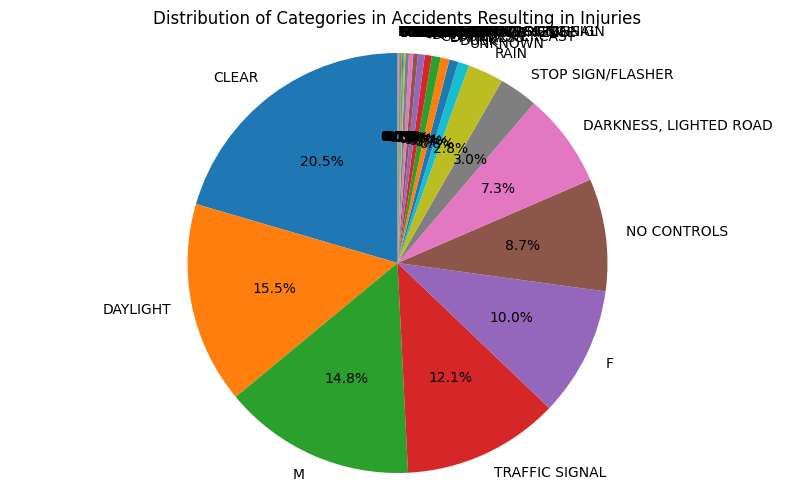

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.pie(category_counts_df['Percentage'], labels=category_counts_df['Value'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Categories in Accidents Resulting in Injuries')
plt.axis('equal')
plt.show()


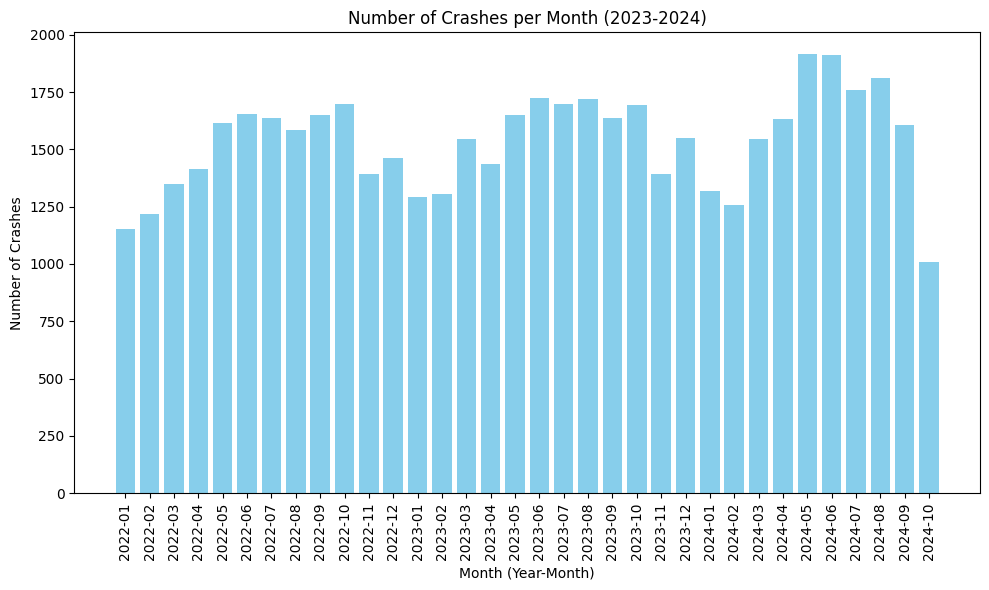

In [45]:
filtered_df['Year_Month'] = filtered_df['CRASH_DATE'].dt.strftime('%Y-%m')  # '%U' gives the week number
week_counts = filtered_df['Year_Month'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(week_counts.index, week_counts.values, width=0.8, color='skyblue')
plt.xlabel('Month (Year-Month)')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes per Month (2023-2024)')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()